In [26]:
# 单元格 1: Notebook 设置与全局配置

import os
import torch
import numpy as np
import pandas as pd # 用于日期处理和插值
import xarray as xr
from datetime import datetime, timedelta
import glob # 用于查找文件
from scipy.interpolate import griddata
import math
import calendar
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Notebook 版本的 tqdm
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F

# --- 项目根目录设定 ---
# 假设此Notebook文件位于项目根目录 "sst_diffusion_baseline/" 下
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) # 获取当前Notebook的工作目录 

# --- 数据路径 ---
DATA_RAW_PATH = os.path.join(PROJECT_ROOT, "data/raw/ERA5")  
DATA_PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data/processed/ERA5") 
PATCHES_PATH = os.path.join(DATA_PROCESSED_PATH, "patches")
LAND_SEA_MASK_PATH = os.path.join(DATA_PROCESSED_PATH, "land_sea_mask.pt")
NORMALIZATION_STATS_PATH = os.path.join(DATA_PROCESSED_PATH, "normalization_stats.pt")

# --- 数据参数 ---
SST_VARIABLE_NAME = 'sst'
LON_VARIABLE_NAME = 'longitude'
LAT_VARIABLE_NAME = 'latitude'
FILENAME_TEMPLATE = "{date_str}_ERA5_daily_mean_sst.nc"

IMAGE_TARGET_HEIGHT = 720
IMAGE_TARGET_WIDTH = 1440

# --- 预处理参数 ---
PATCH_SIZE = 64
STRIDE = 32

DATA_START_DATE = "2020-01-01"
DATA_END_DATE = "2020-03-31"
TRAIN_PERIOD_END_DATE = "2020-02-29"

# --- 特征工程参数 ---
MLP_HIDDEN_DIMS = [128,256]
CONDITION_EMBED_DIM = 256 # MLP的输出维度，也是U-Net期望的条件向量维度

# --- 模型参数 ---
MODEL_ARCHITECTURE = "classic_unet"
HISTORY_DAYS = 30
TARGET_DAYS = 1

UNET_IN_CHANNELS = HISTORY_DAYS + TARGET_DAYS
UNET_OUT_CHANNELS = TARGET_DAYS
UNET_BLOCK_OUT_CHANNELS = (64, 128, 256, 256)
UNET_DOWN_BLOCK_TYPES = tuple(["DownBlock2D"] * len(UNET_BLOCK_OUT_CHANNELS))
UNET_UP_BLOCK_TYPES = tuple(["UpBlock2D"] * len(UNET_BLOCK_OUT_CHANNELS))
UNET_CLASS_EMBED_TYPE = "identity"
UNET_NUM_CLASS_EMBEDS  = CONDITION_EMBED_DIM

# --- 训练参数 ---
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5 # 笔记本中测试时可以改小，例如 1-5 轮
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DDPM_NUM_TRAIN_TIMESTEPS = 1000
DDPM_BETA_SCHEDULE = "linear"

# --- 推理参数 ---
DDPM_NUM_INFERENCE_STEPS = 50
AUTOREGRESSIVE_PREDICT_DAYS = 3

# --- 结果保存路径 ---
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
CHECKPOINT_PATH = os.path.join(RESULTS_PATH, "checkpoints")
FIGURES_PATH = os.path.join(RESULTS_PATH, "figures")
PREDICTIONS_PATH = os.path.join(RESULTS_PATH, "predictions")


# --- 其他 ---
RANDOM_SEED = 42
LOG_INTERVAL = 1000 # 训练时日志打印间隔
SAVE_EPOCH_INTERVAL = 10 # 训练时模型保存间隔 (笔记本中测试时可以改大或不保存)

# 设置随机种子
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"项目根目录设置为: {PROJECT_ROOT}")
print(f"原始数据路径: {DATA_RAW_PATH}")
print(f"预处理数据路径: {DATA_PROCESSED_PATH}")
print(f"设备设置为: {DEVICE}")
print(f"训练轮数 (NUM_EPOCHS) 设置为: {NUM_EPOCHS} (笔记本中可按需调整)")

项目根目录设置为: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton
原始数据路径: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/raw/ERA5
预处理数据路径: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5
设备设置为: cuda
训练轮数 (NUM_EPOCHS) 设置为: 5 (笔记本中可按需调整)


In [3]:
# 单元格 2: 预处理辅助函数与文件加载/裁剪

def ensure_dir(directory_path):
    """确保目录存在，如果不存在则创建"""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"目录已创建: {directory_path}")
    else:
        print(f"目录已存在: {directory_path}")

def load_single_nc_file(file_path):
    """
    加载单个NetCDF文件，并提取SST、经度和纬度数据。
    """
    try:
        ds = xr.open_dataset(file_path)
        sst_data = ds[SST_VARIABLE_NAME] # 使用单元格1定义的全局变量
        lon = ds.get(LON_VARIABLE_NAME, ds.get('lon', None))
        lat = ds.get(LAT_VARIABLE_NAME, ds.get('lat', None))

        if lon is None or lat is None:
            raise ValueError("NetCDF 文件中未找到经度或纬度变量。")

        # 确保SST数据的维度顺序是 (latitude, longitude)
        if sst_data.dims[0] == lon.name and sst_data.dims[1] == lat.name:
            sst_data = sst_data.transpose(lat.name, lon.name)
        elif sst_data.dims[0] != lat.name or sst_data.dims[1] != lon.name:
            if len(sst_data.dims) == 2:
                if ds[lat.name].size == sst_data.shape[0] and ds[lon.name].size == sst_data.shape[1]:
                    sst_data = sst_data.rename({sst_data.dims[0]: lat.name, sst_data.dims[1]: lon.name})
                elif ds[lon.name].size == sst_data.shape[0] and ds[lat.name].size == sst_data.shape[1]:
                     sst_data = sst_data.rename({sst_data.dims[0]: lon.name, sst_data.dims[1]: lat.name})
                     sst_data = sst_data.transpose(lat.name, lon.name)
                else:
                    raise ValueError(
                        f"SST数据维度 {sst_data.dims} 与经纬度名称和大小不匹配。"
                    )
            else:
                raise ValueError(f"SST数据具有意外的维度数量: {len(sst_data.dims)}")

        if 'time' in sst_data.dims and len(sst_data.time) == 1:
            sst_data = sst_data.squeeze('time')
        
        # 确保经纬度坐标是升序的 (xarray 的 interpolate_na 可能需要)
        if lat.values[0] > lat.values[-1]: # 如果是降序
            sst_data = sst_data.reindex({lat.name: sorted(lat.values)})
            lat = sst_data[lat.name] # 更新lat坐标的引用
            print(f"纬度坐标已反转为升序。")
            
        if lon.values[0] > lon.values[-1]: # 如果是降序 (通常经度是0-360升序)
             # 对于经度，如果是0-359然后突然变为负数（如-180到180），处理会更复杂。
             # 假设目前是单调的。
             pass # 通常经度是升序的

        return sst_data, lon, lat
    except Exception as e:
        print(f"加载或处理文件 {file_path} 时出错: {e}")
        raise

def crop_image(data_array: xr.DataArray, target_height: int, target_width: int) -> xr.DataArray:
    """
    裁剪 xarray.DataArray 到目标尺寸。
    """
    current_height, current_width = data_array.shape
    

    if current_height == 721 and target_height == 720:
         # 假设纬度是升序的，去掉第一行（例如南纬90度）或最后一行（例如北纬90度）
         # 如果纬度从-90到90，data_array.isel({data_array.dims[0]: slice(1, None)}) 会去掉-90度
         # 或 data_array.isel({data_array.dims[0]: slice(0, -1)}) 会去掉+90度
         # 这里简单地假设去掉最后一行。如果你的数据纬度是降序，这可能是第一行。
         # 确保 load_single_nc_file 中纬度已转为升序，则 data_array[:-1, :] 是去掉最高的纬度
         print(f"原始高度为721，目标为720，将裁剪掉最后一行纬度。")
         data_array = data_array[:-1, :] 
         current_height = data_array.shape[0]
    
    if current_height == target_height and current_width == target_width:
        return data_array
    elif current_height < target_height or current_width < target_width:
        raise ValueError(f"原始图像 ({current_height},{current_width}) 小于目标尺寸 ({target_height},{target_width})。无法裁剪。")
    


# --- 演示如何使用这些函数 ---
print("\n--- 单元格 2 演示 ---")
ensure_dir(DATA_RAW_PATH) # 确保原始数据目录存在 (虽然这里不创建文件)
ensure_dir(DATA_PROCESSED_PATH) # 确保后续保存文件的目录存在

# 构造一个示例文件名 (你需要确保这个文件确实在 DATA_RAW_PATH 中)
# 我们使用 DATA_START_DATE 来构造第一个文件名
try:
    example_date_dt = datetime.strptime(DATA_START_DATE, "%Y-%m-%d")
    example_date_str_nodash = example_date_dt.strftime("%Y%m%d")
    example_filename = FILENAME_TEMPLATE.format(date_str=example_date_str_nodash)
    example_filepath = os.path.join(DATA_RAW_PATH, example_filename)

    if os.path.exists(example_filepath):
        print(f"\n加载示例文件: {example_filepath}")
        sst_array_raw, lon_coords, lat_coords = load_single_nc_file(example_filepath)
        print(f"成功加载原始SST数据，形状: {sst_array_raw.shape}")
        print(f"SST值范围 (原始): {float(sst_array_raw.min()):.2f} to {float(sst_array_raw.max()):.2f}")
        print(f"纬度范围: {float(lat_coords.min()):.2f} to {float(lat_coords.max()):.2f}, 点数: {len(lat_coords)}")
        print(f"经度范围: {float(lon_coords.min()):.2f} to {float(lon_coords.max()):.2f}, 点数: {len(lon_coords)}")


        print(f"\n尝试裁剪图像到 ({IMAGE_TARGET_HEIGHT}, {IMAGE_TARGET_WIDTH})...")
        sst_array_cropped = crop_image(sst_array_raw, IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH)
        print(f"裁剪后的SST数据形状: {sst_array_cropped.shape}")


    else:
        raise ValueError(f"错误: 示例文件 {example_filepath} 未找到。请确保文件存在或修改 DATA_START_DATE。")


except Exception as e:
    print(f"单元格2演示部分发生错误: {e}")
    # 定义一个空的或假的 sst_array_cropped
    sst_array_cropped = xr.DataArray(np.full((IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH), np.nan), 
                                     dims=('latitude', 'longitude'))


--- 单元格 2 演示 ---
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/raw/ERA5
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5

加载示例文件: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/raw/ERA5\20200101_ERA5_daily_mean_sst.nc
纬度坐标已反转为升序。
成功加载原始SST数据，形状: (721, 1440)
SST值范围 (原始): 270.19 to 306.92
纬度范围: -90.00 to 90.00, 点数: 721
经度范围: 0.00 to 359.75, 点数: 1440

尝试裁剪图像到 (720, 1440)...
原始高度为721，目标为720，将裁剪掉最后一行纬度。
裁剪后的SST数据形状: (720, 1440)



--- 单元格 3 演示 ---
对 'sst_array_cropped' (形状: (720, 1440)) 进行陆地插值...
插值前NaN数量: 351876
插值后NaN数量: 0
插值后的数据形状: (720, 1440)
插值后SST值范围: 270.19 to 306.92
成功：所有NaN值已通过插值或填充为0处理完毕。


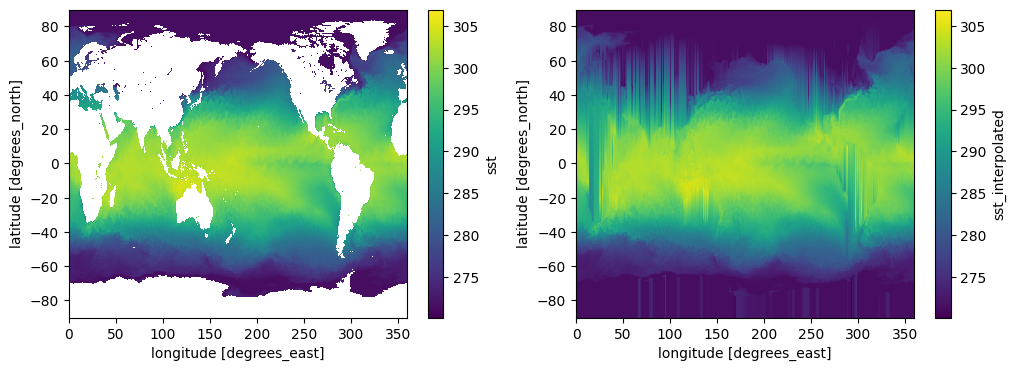

In [4]:
# 单元格 3: 陆地插值函数

def interpolate_land(sst_array: xr.DataArray, method: str = 'linear') -> xr.DataArray:
    """
    对SST数据中的NaN值（陆地）进行插值，采用 pandas DataFrame 的插值方法，然后用0填充。
    sst_array: 原始SST数据，xarray.DataArray，维度应为 (lat, lon)
    method: pandas.DataFrame.interpolate 使用的插值方法 ('linear', 'nearest', 'quadratic', 'cubic', etc.)
    返回: 插值后的SST数据 (NaNs 被替换或填充为0)，xarray.DataArray
    """
    # 确保输入是 xarray.DataArray
    if not isinstance(sst_array, xr.DataArray):
        raise TypeError("输入必须是 xarray.DataArray 类型。")
        
    sst_values_original = sst_array.values.copy() # 获取numpy数组副本

    # 转换为pandas DataFrame
    df = pd.DataFrame(sst_values_original)

    # 1. 先按列插值 (axis=0)
    # limit_direction='both' 会尝试向前和向后填充
    df.interpolate(method=method, axis=0, limit_direction='both', inplace=True)
    
    # 2. 再按行插值 (axis=1)
    df.interpolate(method=method, axis=1, limit_direction='both', inplace=True)

    # 3. 将剩余的所有NaN值（如果插值未能完全覆盖）填充为0
    sst_values_filled = df.fillna(0.0).values

    return xr.DataArray(
        sst_values_filled.astype(np.float32), 
        coords=sst_array.coords, 
        dims=sst_array.dims, 
        name=sst_array.name + "_interpolated" if sst_array.name else "sst_interpolated" # 添加后缀
    )

# --- 演示如何使用 interpolate_land ---
print("\n--- 单元格 3 演示 ---")
# 我们尝试使用上一个单元格 (Cell 2) 演示中可能创建的 sst_array_cropped 变量。
# 检查 sst_array_cropped 是否存在并且是一个 xarray.DataArray
if 'sst_array_cropped' in locals() and isinstance(sst_array_cropped, xr.DataArray):
    print(f"对 'sst_array_cropped' (形状: {sst_array_cropped.shape}) 进行陆地插值...")
    
    # 计算插值前的NaN数量
    nan_count_before = np.isnan(sst_array_cropped.values).sum()
    print(f"插值前NaN数量: {nan_count_before}")

    if nan_count_before == 0:
        print("图像中没有NaN值，无需插值。")
        sst_array_interpolated = sst_array_cropped # 直接使用原图
    elif nan_count_before == sst_array_cropped.size: # 如果整个图像都是NaN
        print("警告:整个图像都是NaN，插值结果将全部为0。")
        sst_array_interpolated = interpolate_land(sst_array_cropped, method='linear')
    else:
        sst_array_interpolated = interpolate_land(sst_array_cropped, method='linear') # 默认用线性插值

    # 计算插值后的NaN数量
    nan_count_after = np.isnan(sst_array_interpolated.values).sum()
    print(f"插值后NaN数量: {nan_count_after}")
    print(f"插值后的数据形状: {sst_array_interpolated.shape}")
    print(f"插值后SST值范围: {float(sst_array_interpolated.min()):.2f} to {float(sst_array_interpolated.max()):.2f}")

    if nan_count_after == 0:
        print("成功：所有NaN值已通过插值或填充为0处理完毕。")
    else:
        print("警告：插值后仍然存在NaN值，请检查插值逻辑或原始数据。")
    
    # (可选) 可视化一小部分来对比插值前后的效果，但对于大型图像可能不直观
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sst_array_cropped.plot()
    plt.subplot(1, 2, 2)
    sst_array_interpolated.plot()
    plt.show()

else:
    print("警告: 变量 'sst_array_cropped' 未在之前的单元格中成功创建或类型不正确。")
    print("无法执行插值演示。请确保单元格2已成功运行并加载了示例文件。")
    # 创建一个假的 sst_array_interpolated 以便后续单元格可能需要它
    sst_array_interpolated = xr.DataArray(np.zeros((IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH), dtype=np.float32), # 用0填充
                                          dims=('latitude', 'longitude'), name="sst_interpolated_dummy")


--- 单元格 4 演示 ---
训练集文件数:60
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5
归一化统计参数文件已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\normalization_stats.pt，直接加载...
加载的归一化统计参数: Min_SST = 269.4762, Max_SST = 306.9226

对插值后的示例数据进行归一化(形状: (720, 1440))...
归一化后的数据形状: (720, 1440)
归一化后数据范围: -0.96 to 1.00


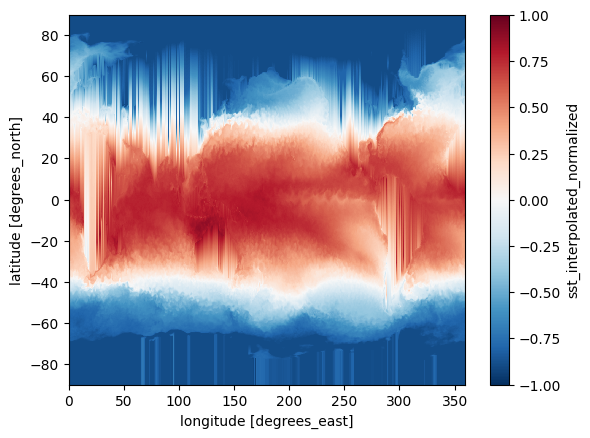

In [5]:
# 单元格 4: 归一化函数与演示

# (必要的导入如 np, xr, torch, os, glob, datetime, timedelta, tqdm 已经在单元格 1 中完成)
# (全局配置变量也已在单元格 1 定义)

def get_normalization_stats(file_paths_for_stats: list, 
                            crop_dims: tuple, 
                            interpolation_method: str = 'linear' # 与 interpolate_land 保持一致
                           ) -> tuple[float, float]:
    """
    计算SST数据的全局最小值和最大值，用于归一化。
    仅使用指定文件列表（训练集文件）的数据进行计算。
    """
    print(f"开始计算归一化统计参数，使用 {len(file_paths_for_stats)} 个训练文件...")
    
    all_sst_values_for_stats = [] # 重命名以示区分
    
    for file_path in tqdm(file_paths_for_stats, desc="读取训练文件计算统计参数"):
        try:
            sst_array_raw, _, _ = load_single_nc_file(file_path) # 使用单元格2定义的函数
            sst_cropped = crop_image(sst_array_raw, crop_dims[0], crop_dims[1]) # 使用单元格2定义的函数
            # 注意: interpolate_land 现在使用 pandas，它需要 xarray.DataArray
            sst_interpolated = interpolate_land(sst_cropped, method=interpolation_method) # 使用单元格3定义的函数
            all_sst_values_for_stats.append(sst_interpolated.values.flatten())
        except Exception as e:
            print(f"处理文件 {file_path} 时跳过（统计计算阶段）: {e}")
            continue
            
    if not all_sst_values_for_stats:
        raise ValueError("未能从任何指定的训练文件中收集到SST数据以计算归一化统计参数。")

    all_sst_values_np = np.concatenate(all_sst_values_for_stats)
    min_sst_val = np.nanmin(all_sst_values_np) 
    max_sst_val = np.nanmax(all_sst_values_np)
    
    print(f"\n归一化统计参数计算完成：Min_SST = {min_sst_val:.4f}, Max_SST = {max_sst_val:.4f}")
    return float(min_sst_val), float(max_sst_val)

def normalize_sst(sst_array: xr.DataArray, min_val: float, max_val: float) -> xr.DataArray:
    """
    将SST数据归一化到 [-1, 1] 范围。
    """
    if max_val == min_val:
        print("警告: SST数据的最小值和最大值相同。归一化结果将全部为0。")
        return xr.full_like(sst_array, 0.0, dtype=np.float32)

    normalized_values = 2 * (sst_array.values - min_val) / (max_val - min_val) - 1
    normalized_values = np.clip(normalized_values, -1.0, 1.0) 
    
    new_name = sst_array.name + "_normalized" if sst_array.name else "sst_normalized"
    return xr.DataArray(
        normalized_values.astype(np.float32), 
        coords=sst_array.coords, 
        dims=sst_array.dims, 
        name=new_name
    )

# --- 演示如何使用这些函数 ---
print("\n--- 单元格 4 演示 ---")

# 1. 确定训练集文件列表 (基于 DATA_START_DATE 和 TRAIN_PERIOD_END_DATE)
train_files_for_stats = []
train_period_start_dt = datetime.strptime(DATA_START_DATE, "%Y-%m-%d")
train_period_end_dt = datetime.strptime(TRAIN_PERIOD_END_DATE, "%Y-%m-%d")

current_dt_iter = train_period_start_dt
while current_dt_iter <= train_period_end_dt:
    date_str_nodash = current_dt_iter.strftime("%Y%m%d")
    filename = FILENAME_TEMPLATE.format(date_str=date_str_nodash)
    file_path = os.path.join(DATA_RAW_PATH, filename)
    if os.path.exists(file_path):
        train_files_for_stats.append(file_path)
    current_dt_iter += timedelta(days=1)
print(f"训练集文件数:{len(train_files_for_stats)}")

# 2. 计算归一化统计参数
ensure_dir(DATA_PROCESSED_PATH) # 确保预处理数据目录存在
if not os.path.exists(NORMALIZATION_STATS_PATH):
    global_min_sst, global_max_sst = get_normalization_stats(
        train_files_for_stats, 
        crop_dims=(IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH), 
        interpolation_method='linear' # 使用线性插值
    )
    torch.save({'min_sst': global_min_sst, 'max_sst': global_max_sst}, NORMALIZATION_STATS_PATH)
    print(f"归一化统计参数已保存到: {NORMALIZATION_STATS_PATH}")
else:
    print(f"归一化统计参数文件已存在: {NORMALIZATION_STATS_PATH}，直接加载...")
    stats = torch.load(NORMALIZATION_STATS_PATH)
    global_min_sst = stats['min_sst']
    global_max_sst = stats['max_sst']
    print(f"加载的归一化统计参数: Min_SST = {global_min_sst:.4f}, Max_SST = {global_max_sst:.4f}")

# 3. 对示例数据进行归一化
print(f"\n对插值后的示例数据进行归一化(形状: {sst_array_interpolated.shape})...")
sst_array_normalized = normalize_sst(sst_array_interpolated, global_min_sst, global_max_sst)
print(f"归一化后的数据形状: {sst_array_normalized.shape}")
print(f"归一化后数据范围: {float(sst_array_normalized.min()):.2f} to {float(sst_array_normalized.max()):.2f}")
# 可视化归一化前后的数据
sst_array_normalized.plot()


--- 单元格 5 演示 ---
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5
陆地海洋掩码文件已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\land_sea_mask.pt，直接加载...
创建的陆地海洋掩码形状: torch.Size([720, 1440]), 数据类型: torch.bool


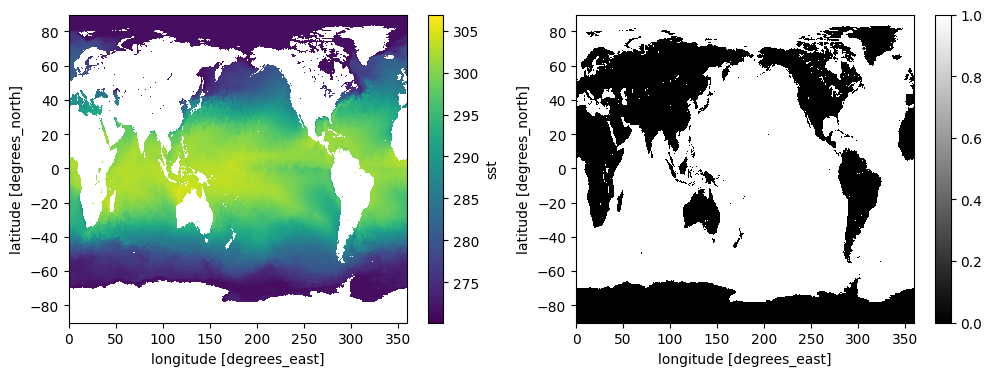

In [6]:
# 单元格 5: 创建陆地海洋掩码函数与演示

def create_land_sea_mask(raw_sst_array:xr.DataArray) -> torch.Tensor:
    """
    创建全局海洋陆地掩码，海洋：True，陆地：Fales
    raw_sst_array: xarray.DataArray，包含原始SST数据,需要经过裁剪。
    """
    return torch.from_numpy(
        (~np.isnan(raw_sst_array.values)).astype(bool)
    )

print("\n--- 单元格 5 演示 ---")
if sst_array_cropped.shape != (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH):
    raise ValueError(f"警告: sst_array_cropped 的形状 {sst_array_cropped.shape} 与目标形状 {IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH} 不匹配。")

# 保存陆地海洋掩码
ensure_dir(DATA_PROCESSED_PATH) # 确保预处理数据目录存在
if not os.path.exists(LAND_SEA_MASK_PATH):
    land_sea_mask = create_land_sea_mask(sst_array_cropped)
    torch.save(land_sea_mask, LAND_SEA_MASK_PATH)
    print(f"陆地海洋掩码已保存到: {LAND_SEA_MASK_PATH}")    
else:
    land_sea_mask = torch.load(LAND_SEA_MASK_PATH)
    print(f"陆地海洋掩码文件已存在: {LAND_SEA_MASK_PATH}，直接加载...")
print(f"创建的陆地海洋掩码形状: {land_sea_mask.shape}, 数据类型: {land_sea_mask.dtype}")

mask_xr = xr.DataArray(
    land_sea_mask.numpy(), 
    dims=('latitude', 'longitude'), 
    coords={'latitude': sst_array_cropped.latitude, 'longitude': sst_array_cropped.longitude}
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sst_array_cropped.plot()
plt.subplot(1, 2, 2)
mask_xr.plot(cmap='gray')
plt.show()

In [7]:
# 单元格 6: 创建并保存图像块 (Patches)

def create_and_save_patches(
    daily_sst_normalized_array: xr.DataArray, 
    date_str: str, # 'YYYY-MM-DD' 格式
    patch_size: int, 
    stride: int, 
    output_base_dir: str # 例如 config.PATCHES_PATH
):
    """
    从单日已归一化的SST图像中提取patches并保存。每日patches保存在一个文件中。包括原始信息和位置信息。
    """

    height,width = daily_sst_normalized_array.shape
    sst_np = daily_sst_normalized_array.values
    

    ensure_dir(output_base_dir)
    patches_one_day = [] # 存储单日的所有patches信息
    for r in range(0, height - patch_size + 1, stride):
        for c in range(0, width - patch_size + 1, stride):
            patch_np = sst_np[r:r + patch_size, c:c + patch_size]

            patch_data = {
                'sst_patch': torch.from_numpy(patch_np.astype(np.float32)),
                'coords':(r,c)
            }
            patches_one_day.append(patch_data)
    daily_patches_filename = f"{date_str}_patches.pt"
    filepath = os.path.join(output_base_dir, daily_patches_filename)
    torch.save(patches_one_day, filepath)
    print(f"Saved {len(patches_one_day)} patches for {date_str}")
    return len(patches_one_day)  # 返回单日patches的数量

print("\n--- 单元格 6 演示 ---")

ensure_dir(PATCHES_PATH) # 确保patches目录存在
sample_date_str = DATA_START_DATE # 使用单元格1定义的全局变量
num_pathes_created_one_day = create_and_save_patches(
    daily_sst_normalized_array=sst_array_normalized, 
    date_str=sample_date_str, # 示例日期
    patch_size=PATCH_SIZE, 
    stride=STRIDE, 
    output_base_dir=PATCHES_PATH
)
print(f"为日期 {sample_date_str} 创建了 {num_pathes_created_one_day} 个patches。")


--- 单元格 6 演示 ---
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\patches
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\patches
Saved 924 patches for 2020-01-01
为日期 2020-01-01 创建了 924 个patches。


In [8]:
# 单元格 7: run_preprocessing 总控函数
def run_prepocess():
    """
    执行完整的预处理流程：
    1. 确定文件列表和日期范围。
    2. (如果不存在) 计算并保存归一化统计参数 (仅基于训练期数据)。
    3. (如果不存在) 创建并保存陆地海洋掩码。
    4. 逐日处理数据：加载、裁剪、插值、归一化。
    5. 调用 create_and_save_patches 将每日所有patches保存到单个汇总文件中。
    """
    ensure_dir(DATA_PROCESSED_PATH) # 确保预处理数据目录存在
    ensure_dir(PATCHES_PATH) # 确保patches目录存在
    # 如果有其他结果目录，也可以在这里确保它们存在
    ensure_dir(RESULTS_PATH) 
    ensure_dir(CHECKPOINT_PATH)
    ensure_dir(FIGURES_PATH)
    ensure_dir(PREDICTIONS_PATH)

    # 1. 所有可用文件和对应日期
    start_date_dt = datetime.strptime(DATA_START_DATE, "%Y-%m-%d")
    end_date_dt = datetime.strptime(DATA_END_DATE, "%Y-%m-%d")
    train_period_end_dt = datetime.strptime(TRAIN_PERIOD_END_DATE, "%Y-%m-%d")

    all_file_paths = []
    date_objects_for_prepocess = []

    current_dt_iter = start_date_dt
    while current_dt_iter <= end_date_dt:
        date_str_nodash = current_dt_iter.strftime("%Y%m%d")
        filename = FILENAME_TEMPLATE.format(date_str=date_str_nodash)
        file_path = os.path.join(DATA_RAW_PATH, filename)
        if os.path.exists(file_path):
            all_file_paths.append(file_path)
            date_objects_for_prepocess.append(current_dt_iter)
        else:
            raise ValueError(f"错误: 文件 {file_path} 不存在。请检查原始数据路径和文件名格式。")
        current_dt_iter += timedelta(days=1)
    
    print(f"找到 {len(all_file_paths)} 个可用的原始数据文件。")
    
    # 2. 计算归一化统计参数 (仅基于训练期数据)
    train_files_for_stats = []
    for i,dt_obj in enumerate(date_objects_for_prepocess):
        if dt_obj <= train_period_end_dt:
            train_files_for_stats.append(all_file_paths[i])

    if not train_files_for_stats:
        raise ValueError("未找到任何训练期数据文件。请检查 DATA_START_DATE 和 TRAIN_PERIOD_END_DATE 设置。")
    
    print(f"使用截止到 {TRAIN_PERIOD_END_DATE} 的 {len(train_files_for_stats)} 个训练文件计算归一化统计参数...")

    if not os.path.exists(NORMALIZATION_STATS_PATH):
        min_sst, max_sst = get_normalization_stats(
            train_files_for_stats, 
            crop_dims=(IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH), 
            interpolation_method='linear'
        )
        torch.save({'min_sst': min_sst, 'max_sst': max_sst}, NORMALIZATION_STATS_PATH)
        print(f"归一化统计参数已保存到: {NORMALIZATION_STATS_PATH}")
    else:
        stats = torch.load(NORMALIZATION_STATS_PATH)
        min_sst , max_sst = stats['min_sst'], stats['max_sst']
        print(f"从{NORMALIZATION_STATS_PATH}加载的归一化统计参数: Min_SST = {min_sst:.4f}, Max_SST = {max_sst:.4f}")

    # 3. 创建陆地海洋掩码 (如果不存在)
    if not os.path.exists(LAND_SEA_MASK_PATH):
        print(f"使用{all_file_paths[0]}创建陆地海洋掩码...")
        sample_sst_raw,_,_ = load_single_nc_file(all_file_paths[0])
        sample_sst_cropped = crop_image(sample_sst_raw, IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH)
        land_sea_mask = create_land_sea_mask(sample_sst_cropped)
        torch.save(land_sea_mask, LAND_SEA_MASK_PATH)
        print(f"陆地海洋掩码已保存到: {LAND_SEA_MASK_PATH}")
    else:
        print(f"陆地海洋掩码文件已存在: {LAND_SEA_MASK_PATH}")
    
    # 4. 逐日处理数据(加载、裁剪、插值、归一化，分割)
    print(f"开始从{DATA_START_DATE}到{DATA_END_DATE}处理每日数据并保存patches...")
    for i , filename in enumerate(tqdm(all_file_paths,desc="预处理每日数据")):
        date_obj = date_objects_for_prepocess[i]
        date_str = date_obj.strftime("%Y-%m-%d")
        if os.path.exists(os.path.join(PATCHES_PATH, f"{date_str}_patches.pt")):
            print(f"跳过 {date_str}，已存在处理后的patches文件。")
            continue
        
        try:
            # 1. 加载数据
            sst_raw, _, _ = load_single_nc_file(filename)

            # 2. 裁剪到目标尺寸
            sst_cropped = crop_image(sst_raw, IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH)

            # 3. 插值陆地海洋掩码
            sst_interpolated = interpolate_land(sst_cropped, method='linear')

            # 4. 归一化
            sst_normalized = normalize_sst(sst_interpolated, min_sst, max_sst)

            # 5. 创建并保存patches
            num_patches = create_and_save_patches(
                daily_sst_normalized_array=sst_normalized, 
                date_str=date_str, 
                patch_size=PATCH_SIZE, 
                stride=STRIDE, 
                output_base_dir=PATCHES_PATH
            )
            
        except Exception as e:
            print(f"处理文件 {filename} 时发生错误: {e}")

    print("\n数据预处理流程 (run_preprocessing) 全部完成。")
    print(f"归一化参数是基于 {DATA_START_DATE} 至 {TRAIN_PERIOD_END_DATE} 的数据计算的。")
    print(f"所有日期的每日汇总patch文件已处理并保存到 {PATCHES_PATH}。")

# 执行预处理流程
run_prepocess()

目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\patches
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\checkpoints
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\figures
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\predictions
找到 91 个可用的原始数据文件。
使用截止到 2020-02-29 的 60 个训练文件计算归一化统计参数...
从d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\normalization_stats.pt加载的归一化统计参数: Min_SST = 269.4762, Max_SST = 306.9226
陆地海洋掩码文件已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\data/processed/ERA5\land_sea_mask.pt
开始从2020-01-01到2020-03-31处理每日数据并保存patches...


预处理每日数据:   0%|          | 0/91 [00:00<?, ?it/s]

跳过 2020-01-01，已存在处理后的patches文件。
跳过 2020-01-02，已存在处理后的patches文件。
跳过 2020-01-03，已存在处理后的patches文件。
跳过 2020-01-04，已存在处理后的patches文件。
跳过 2020-01-05，已存在处理后的patches文件。
跳过 2020-01-06，已存在处理后的patches文件。
跳过 2020-01-07，已存在处理后的patches文件。
跳过 2020-01-08，已存在处理后的patches文件。
跳过 2020-01-09，已存在处理后的patches文件。
跳过 2020-01-10，已存在处理后的patches文件。
跳过 2020-01-11，已存在处理后的patches文件。
跳过 2020-01-12，已存在处理后的patches文件。
跳过 2020-01-13，已存在处理后的patches文件。
跳过 2020-01-14，已存在处理后的patches文件。
跳过 2020-01-15，已存在处理后的patches文件。
跳过 2020-01-16，已存在处理后的patches文件。
跳过 2020-01-17，已存在处理后的patches文件。
跳过 2020-01-18，已存在处理后的patches文件。
跳过 2020-01-19，已存在处理后的patches文件。
跳过 2020-01-20，已存在处理后的patches文件。
跳过 2020-01-21，已存在处理后的patches文件。
跳过 2020-01-22，已存在处理后的patches文件。
跳过 2020-01-23，已存在处理后的patches文件。
跳过 2020-01-24，已存在处理后的patches文件。
跳过 2020-01-25，已存在处理后的patches文件。
跳过 2020-01-26，已存在处理后的patches文件。
跳过 2020-01-27，已存在处理后的patches文件。
跳过 2020-01-28，已存在处理后的patches文件。
跳过 2020-01-29，已存在处理后的patches文件。
跳过 2020-01-30，已存在处理后的patches文件。
跳过 2020-01-31，已存在处理后的patches文件。
跳过 2020-

In [9]:
# 检查一个.pt文件
example_filename = os.path.join(PATCHES_PATH, f"{DATA_START_DATE}_patches.pt")
example_file = torch.load(example_filename)
example_file[:3]  # 显示前3个patches的信息

[{'sst_patch': tensor([[-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          ...,
          [-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8908, -0.8939, -0.8940,  ..., -0.8940, -0.8940, -0.8940]]),
  'coords': (0, 0)},
 {'sst_patch': tensor([[-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          ...,
          [-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940],
          [-0.8940, -0.8940, -0.8940,  ..., -0.8940, -0.8940, -0.8940]]),
  'coords': (0, 32)},
 {'sst_patch': tensor([[-0.8940, 

In [10]:
# 单元格 8: 特征工程 (时间/空间编码与条件MLP)

# 1. time_embedding
def get_time_features(date_str: str, reference_year: int = 2020):
    """
    为给定的日期字符串生成时间特征。
    包括：归一化的年份、月份和日期的周期性编码（正弦/余弦）。
    返回: torch.Tensor: 包含时间特征的一维张量 (5个特征)。
    """
    dt_obj = datetime.strptime(date_str, "%Y-%m-%d")
    year_norm = (dt_obj.year - reference_year) / 10.0  # 假设2020年为参考年
    month_sin = np.sin(2 * np.pi * dt_obj.month / 12.0)
    month_cos = np.cos(2 * np.pi * dt_obj.month / 12.0)
    days_in_month = calendar.monthrange(dt_obj.year, dt_obj.month)[1]  # 获取当月天数
    day_sin = np.sin(2 * np.pi * dt_obj.day / days_in_month)
    day_cos = np.cos(2 * np.pi * dt_obj.day / days_in_month)
    return torch.tensor([year_norm, month_sin, month_cos, day_sin, day_cos], dtype=torch.float32)

# 2.spatail_embedding
def get_spatial_features(patch_coords: tuple, full_image_dims: tuple, patch_size: int):
    """
    为给定的patch坐标生成归一化的空间特征 (左上角坐标归一化)。
    返回: torch.Tensor: 包含归一化空间特征的一维张量 (2个特征)。
    """
    row, col = patch_coords
    height, width = full_image_dims
    normalized_row = row / (height - patch_size)
    normalized_col = col / (width - patch_size)
    return torch.tensor([normalized_row, normalized_col], dtype=torch.float32)

# 3. 条件MLP
class ConditionalMLP(nn.Module):
    """
    一个MLP，将编码后的时间和空间特征映射为条件嵌入向量 C_cond。
    """
    def __init__(self,num_time_features:int,num_space_features:int,hidden_dims:list,output_dims:int):
        super().__init__()
        input_dim = num_time_features + num_space_features
        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dims))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self,time_features:torch.Tensor,spatial_features:torch.Tensor) -> torch.Tensor:
        """
        前向传播：将时间和空间特征拼接后通过MLP。
        time_features: torch.Tensor, shape (batch_size, num_time_features)
        spatial_features: torch.Tensor, shape (batch_size, num_space_features)
        返回: torch.Tensor, shape (batch_size, output_dims)
        """
        combined_features = torch.cat((time_features, spatial_features), dim=1)
        return self.mlp(combined_features)
    
# 实例化MLP
def get_conditional_mlp():
    """根据config中的参数实例化条件MLP"""
    num_time_features = 5  # 5个时间特征
    num_sparital_features = 2  # 2个空间特征

    return ConditionalMLP(
        num_time_features=num_time_features,
        num_space_features=num_sparital_features,
        hidden_dims=MLP_HIDDEN_DIMS,  # 从配置中获取隐藏层维度
        output_dims=CONDITION_EMBED_DIM     # 输出维度
    )


In [23]:
import os
from datetime import datetime, timedelta
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

class SSTDataset(Dataset):
    def __init__(self, mode='train'):
        super().__init__()
        self.mode = mode
        self.history_days = HISTORY_DAYS
        self.train_period_end_dt = datetime.strptime(TRAIN_PERIOD_END_DATE, "%Y-%m-%d")

        if self.mode == 'train':
            self.start_date_dt = datetime.strptime(DATA_START_DATE, "%Y-%m-%d")
            self.end_date_dt = self.train_period_end_dt
        elif self.mode == 'test':
            self.start_date_dt = self.train_period_end_dt + timedelta(days=1)
            self.end_date_dt = datetime.strptime(DATA_END_DATE, "%Y-%m-%d")
        else:
            raise ValueError(f"未知的模式: {self.mode}。mode 请使用 'train' 或 'test'。")

        print(f"为 '{self.mode}' 模式初始化 SSTDataset，日期范围: {self.start_date_dt.strftime('%Y-%m-%d')} 到 {self.end_date_dt.strftime('%Y-%m-%d')}")

        # 加载所有patch到内存
        self.all_loaded_patches = defaultdict(dict)  # [date_str][coords] = sst_tensor
        print("开始加载所有每日patch汇总文件到内存...")

        temp_date = self.start_date_dt
        date_range_for_loading = []
        while temp_date <= self.end_date_dt:
            date_range_for_loading.append(temp_date)
            temp_date += timedelta(days=1)

        for current_load_dt in tqdm(date_range_for_loading, desc="加载每日patches"):
            date_str = current_load_dt.strftime("%Y-%m-%d")
            file_path = os.path.join(PATCHES_PATH, f"{date_str}_patches.pt")
            if os.path.exists(file_path):
                try:
                    patches = torch.load(file_path)
                    for patch in patches:
                        coords = tuple(patch['coords'])
                        self.all_loaded_patches[date_str][coords] = patch['sst_patch']
                except Exception as e:
                    print(f"加载文件 {file_path} 时发生错误: {e}")
            else:
                print(f"警告: 文件 {file_path} 不存在，跳过加载。")

        if not self.all_loaded_patches:
            raise ValueError(f"未能加载任何patches数据，请检查 {PATCHES_PATH} 中的文件是否存在。")

        print(f"已成功加载 {len(self.all_loaded_patches)} 天的patches数据。")

        # 构造样本序列
        self.samples = []
        print("开始构造样本序列...")

        example_date = next(iter(self.all_loaded_patches))
        coords_set = set(self.all_loaded_patches[example_date].keys())
        if not coords_set:
            raise ValueError("未找到任何有效的patch坐标，请检查加载的patches数据。")
        print(f"所有日期的patches共有 {len(coords_set)} 个唯一坐标。")

        available_dates = sorted(self.all_loaded_patches.keys())

        for coords in tqdm(coords_set, desc=f"为 {self.mode} 构造样本序列"):
            for idx in range(self.history_days, len(available_dates)):
                target_date = available_dates[idx]
                history_date_strs = [
                    (datetime.strptime(target_date, "%Y-%m-%d") - timedelta(days=d)).strftime("%Y-%m-%d")
                    for d in range(self.history_days, 0, -1)
                ]
                if all(d in self.all_loaded_patches and coords in self.all_loaded_patches[d] for d in history_date_strs):
                    sample = {
                        'history_date_strs': history_date_strs,
                        'target_date_str': target_date,
                        'coords': coords,
                    }
                    self.samples.append(sample)

        print(f"为 '{self.mode}' 模式成功构造了 {len(self.samples)} 个样本序列。")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        coords = sample['coords']

        hist_stack = torch.stack([
            self.all_loaded_patches[d][coords] for d in sample['history_date_strs']
        ], dim=0)  # shape: [HISTORY_DAYS, 1, patch_h, patch_w]

        target_patch = self.all_loaded_patches[sample['target_date_str']][coords]
        target = target_patch.unsqueeze(0)  # shape: [1, patch_h, patch_w]

        time_feat = get_time_features(
            sample['target_date_str'],
            reference_year=datetime.strptime(DATA_START_DATE, "%Y-%m-%d").year
        )
        spatial_feat = get_spatial_features(
            coords,
            full_image_dims=(IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH),
            patch_size=PATCH_SIZE
        )

        return hist_stack, target, time_feat, spatial_feat

# print("\n--- 单元格 8 测试 ---")
# train_dataset = SSTDataset(mode='train')
# train_dataloader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True, 
#     pin_memory=True
# )
# for hist_stack, target, time_feat, spatial_feat in train_dataloader:
#     print(f"历史堆栈形状: {hist_stack.shape}\n 目标形状: {target.shape}\n 时间特征形状: {time_feat.shape}\n 空间特征形状: {spatial_feat.shape}")
#     print(f"时间特征示例: {time_feat[0]}")
#     print(f"空间特征示例: {spatial_feat[0]}")
#     break  # 只查看第一个batch的输出


--- 单元格 8 演示 ---
为 'train' 模式初始化 SSTDataset，日期范围: 2020-01-01 到 2020-02-29
开始加载所有每日patch汇总文件到内存...


加载每日patches:   0%|          | 0/60 [00:00<?, ?it/s]

已成功加载 60 天的patches数据。
开始构造样本序列...
所有日期的patches共有 924 个唯一坐标。


为 train 构造样本序列:   0%|          | 0/924 [00:00<?, ?it/s]

为 'train' 模式成功构造了 27720 个样本序列。
历史堆栈形状: torch.Size([4, 30, 64, 64])
 目标形状: torch.Size([4, 1, 64, 64])
 时间特征形状: torch.Size([4, 5])
 空间特征形状: torch.Size([4, 2])
时间特征示例: tensor([0.0000, 0.8660, 0.5000, 0.8835, 0.4684])
空间特征示例: tensor([0.2439, 0.3721])


In [24]:
# 单元格 10: 模型定义 (DiffusionUNetWithMLP)

from diffusers import UNet2DModel # 确保导入

class DiffusionUNetWithMLP(nn.Module):
    """
    封装了条件MLP和U-Net的扩散模型。
    """
    def __init__(self):
        super().__init__()

        # 1. 初始化条件MLP (从单元格8定义的函数获取)
        self.conditional_mlp = get_conditional_mlp() 

        # 2. 初始化U-Net (UNet2DModel)
        # 参数从单元格1定义的全局配置中读取
        self.unet = UNet2DModel(
            sample_size=(PATCH_SIZE, PATCH_SIZE), 
            in_channels=UNET_IN_CHANNELS,        
            out_channels=UNET_OUT_CHANNELS,      
            block_out_channels=UNET_BLOCK_OUT_CHANNELS,
            down_block_types=UNET_DOWN_BLOCK_TYPES,
            up_block_types=UNET_UP_BLOCK_TYPES,
            class_embed_type=UNET_CLASS_EMBED_TYPE,
            num_class_embeds=UNET_NUM_CLASS_EMBEDS    
            # 根据需要可以添加其他 UNet2DModel 支持的参数，例如:
            # norm_num_groups=32, 
            # dropout=0.0
        )

    def forward(self, 
                history_patches: torch.Tensor,    # (B, HISTORY_DAYS, H, W)
                noisy_target_patch: torch.Tensor, # (B, 1, H, W) - 带噪声的目标patch
                timestep: torch.Tensor,           # (B,) - 扩散时间步
                raw_time_features: torch.Tensor,  # (B, num_raw_time_features)
                raw_spatial_features: torch.Tensor # (B, num_raw_space_features)
               ) -> torch.Tensor:
        """
        模型的前向传播。
        返回: U-Net预测的噪声，形状 (B, UNET_OUT_CHANNELS, H, W)
        """
        # 1. 通过MLP生成条件嵌入 C_cond
        condition_embedding_C_cond = self.conditional_mlp(raw_time_features, raw_spatial_features)

        # 2. 准备U-Net的输入图像数据
        unet_input = torch.cat((history_patches, noisy_target_patch), dim=1) # (B, 31, H, W)

        # 3. U-Net前向传播
        # 当 class_embed_type="identity", class_labels 参数接收的是实际的嵌入向量
        predicted_noise = self.unet(
            sample=unet_input,
            timestep=timestep,
            class_labels=condition_embedding_C_cond 
        ).sample 

        return predicted_noise

# --- 辅助函数：根据config实例化并返回主模型 ---
def get_diffusion_model():
    """
    根据 config 中的 MODEL_ARCHITECTURE 创建并返回主模型实例。
    """
    # MODEL_ARCHITECTURE 来自单元格1的全局配置
    if MODEL_ARCHITECTURE == "classic_unet":
        print(f"初始化模型: DiffusionUNetWithMLP (基于 UNet2DModel)")
        model_instance = DiffusionUNetWithMLP() # 重命名变量以防混淆
    # elif MODEL_ARCHITECTURE == "another_custom_model":
    #     model_instance = AnotherCustomModel() 
    else:
        raise ValueError(f"未知的模型架构在config中定义: {MODEL_ARCHITECTURE}")
    return model_instance

print("\n--- 单元格 10 演示 (可选) ---")
try:
    # 尝试实例化模型
    print("尝试实例化 DiffusionUNetWithMLP...")
    demo_model = get_diffusion_model()
    print("模型实例化成功。")
    print(demo_model) # 可以打印模型结构
    
    # 准备一些假的输入数据进行一次前向传播测试 (确保形状正确)
    print("\n尝试一次假的前向传播...")
    dummy_batch_size = 2
    dummy_history = torch.randn(dummy_batch_size, HISTORY_DAYS, PATCH_SIZE, PATCH_SIZE)
    dummy_noisy_target = torch.randn(dummy_batch_size, TARGET_DAYS, PATCH_SIZE, PATCH_SIZE)
    dummy_timestep = torch.randint(0, DDPM_NUM_TRAIN_TIMESTEPS, (dummy_batch_size,)).long()
    
    # 假设原始时间特征有5个，空间特征有2个 (与features.py中的定义一致)
    num_raw_time_feat = 5
    num_raw_space_feat = 2
    dummy_raw_time = torch.randn(dummy_batch_size, num_raw_time_feat)
    dummy_raw_space = torch.randn(dummy_batch_size, num_raw_space_feat)
    
    # 将模型和数据移到设备
    demo_model.to(DEVICE)
    dummy_history = dummy_history.to(DEVICE)
    dummy_noisy_target = dummy_noisy_target.to(DEVICE)
    dummy_timestep = dummy_timestep.to(DEVICE)
    dummy_raw_time = dummy_raw_time.to(DEVICE)
    dummy_raw_space = dummy_raw_space.to(DEVICE)
    
    with torch.no_grad(): # 测试时不需要梯度
        prediction = demo_model(dummy_history, dummy_noisy_target, dummy_timestep, dummy_raw_time, dummy_raw_space)
    print(f"假的前向传播输出形状: {prediction.shape}") # 应为 (dummy_batch_size, UNET_OUT_CHANNELS, PATCH_SIZE, PATCH_SIZE)
    if prediction.shape == (dummy_batch_size, UNET_OUT_CHANNELS, PATCH_SIZE, PATCH_SIZE):
        print("前向传播形状符合预期。")
    else:
        print("错误：前向传播形状不符合预期！")

except Exception as e:
    print(f"单元格 10 演示部分发生错误: {e}")
    import traceback
    traceback.print_exc()


--- 单元格 10 演示 (可选) ---
尝试实例化 DiffusionUNetWithMLP...
初始化模型: DiffusionUNetWithMLP (基于 UNet2DModel)
模型实例化成功。
DiffusionUNetWithMLP(
  (conditional_mlp): ConditionalMLP(
    (mlp): Sequential(
      (0): Linear(in_features=7, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (unet): UNet2DModel(
    (conv_in): Conv2d(31, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=64, out_features=256, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=256, out_features=256, bias=True)
    )
    (class_embedding): Identity()
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (c

开始训练流程的主体代码...
确保输出目录存在...
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\checkpoints
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\figures
初始化训练数据集...
为 'train' 模式初始化 SSTDataset，日期范围: 2020-01-01 到 2020-02-29
开始加载所有每日patch汇总文件到内存...


加载每日patches:   0%|          | 0/60 [00:00<?, ?it/s]

已成功加载 60 天的patches数据。
开始构造样本序列...
所有日期的patches共有 924 个唯一坐标。


为 train 构造样本序列:   0%|          | 0/924 [00:00<?, ?it/s]

为 'train' 模式成功构造了 27720 个样本序列。
训练数据加载器准备完毕，每个epoch包含 6930 个批次。
初始化模型...
初始化模型: DiffusionUNetWithMLP (基于 UNet2DModel)
模型参数总数: 24101377
模型已移动到设备: cuda
DDPM噪声调度器 (linear schedule, 1000 步) 已初始化。
优化器 AdamW 已初始化，学习率: 0.0001
学习率调度器 (linear) 已初始化，总训练步数: 34650
开始训练，共 5 轮。


轮次 1/5:   0%|          | 0/6930 [00:00<?, ?it/s]

    [轮次 1, 批次 10/6930] 平均批次损失 (至今): 0.5768
    [轮次 1, 批次 20/6930] 平均批次损失 (至今): 0.3837
    [轮次 1, 批次 30/6930] 平均批次损失 (至今): 0.2916
    [轮次 1, 批次 40/6930] 平均批次损失 (至今): 0.2427
    [轮次 1, 批次 50/6930] 平均批次损失 (至今): 0.2119
    [轮次 1, 批次 60/6930] 平均批次损失 (至今): 0.1900
    [轮次 1, 批次 70/6930] 平均批次损失 (至今): 0.1745
    [轮次 1, 批次 80/6930] 平均批次损失 (至今): 0.1584
    [轮次 1, 批次 90/6930] 平均批次损失 (至今): 0.1450
    [轮次 1, 批次 100/6930] 平均批次损失 (至今): 0.1352
    [轮次 1, 批次 110/6930] 平均批次损失 (至今): 0.1263
    [轮次 1, 批次 120/6930] 平均批次损失 (至今): 0.1189
    [轮次 1, 批次 130/6930] 平均批次损失 (至今): 0.1119
    [轮次 1, 批次 140/6930] 平均批次损失 (至今): 0.1063
    [轮次 1, 批次 150/6930] 平均批次损失 (至今): 0.1039
    [轮次 1, 批次 160/6930] 平均批次损失 (至今): 0.1009
    [轮次 1, 批次 170/6930] 平均批次损失 (至今): 0.0973
    [轮次 1, 批次 180/6930] 平均批次损失 (至今): 0.0932
    [轮次 1, 批次 190/6930] 平均批次损失 (至今): 0.0897
    [轮次 1, 批次 200/6930] 平均批次损失 (至今): 0.0863
    [轮次 1, 批次 210/6930] 平均批次损失 (至今): 0.0842
    [轮次 1, 批次 220/6930] 平均批次损失 (至今): 0.0821
    [轮次 1, 批次 230/6930] 平均批次损失 (至今): 0.07

轮次 2/5:   0%|          | 0/6930 [00:00<?, ?it/s]

    [轮次 2, 批次 10/6930] 平均批次损失 (至今): 0.0038
    [轮次 2, 批次 20/6930] 平均批次损失 (至今): 0.0035
    [轮次 2, 批次 30/6930] 平均批次损失 (至今): 0.0031
    [轮次 2, 批次 40/6930] 平均批次损失 (至今): 0.0028
    [轮次 2, 批次 50/6930] 平均批次损失 (至今): 0.0029
    [轮次 2, 批次 60/6930] 平均批次损失 (至今): 0.0031
    [轮次 2, 批次 70/6930] 平均批次损失 (至今): 0.0029
    [轮次 2, 批次 80/6930] 平均批次损失 (至今): 0.0030
    [轮次 2, 批次 90/6930] 平均批次损失 (至今): 0.0029
    [轮次 2, 批次 100/6930] 平均批次损失 (至今): 0.0030
    [轮次 2, 批次 110/6930] 平均批次损失 (至今): 0.0028
    [轮次 2, 批次 120/6930] 平均批次损失 (至今): 0.0028
    [轮次 2, 批次 130/6930] 平均批次损失 (至今): 0.0027
    [轮次 2, 批次 140/6930] 平均批次损失 (至今): 0.0026
    [轮次 2, 批次 150/6930] 平均批次损失 (至今): 0.0025
    [轮次 2, 批次 160/6930] 平均批次损失 (至今): 0.0025
    [轮次 2, 批次 170/6930] 平均批次损失 (至今): 0.0024
    [轮次 2, 批次 180/6930] 平均批次损失 (至今): 0.0024
    [轮次 2, 批次 190/6930] 平均批次损失 (至今): 0.0024
    [轮次 2, 批次 200/6930] 平均批次损失 (至今): 0.0024
    [轮次 2, 批次 210/6930] 平均批次损失 (至今): 0.0031
    [轮次 2, 批次 220/6930] 平均批次损失 (至今): 0.0034
    [轮次 2, 批次 230/6930] 平均批次损失 (至今): 0.00

轮次 3/5:   0%|          | 0/6930 [00:00<?, ?it/s]

    [轮次 3, 批次 10/6930] 平均批次损失 (至今): 0.0008
    [轮次 3, 批次 20/6930] 平均批次损失 (至今): 0.0008
    [轮次 3, 批次 30/6930] 平均批次损失 (至今): 0.0008
    [轮次 3, 批次 40/6930] 平均批次损失 (至今): 0.0007
    [轮次 3, 批次 50/6930] 平均批次损失 (至今): 0.0023
    [轮次 3, 批次 60/6930] 平均批次损失 (至今): 0.0022
    [轮次 3, 批次 70/6930] 平均批次损失 (至今): 0.0036
    [轮次 3, 批次 80/6930] 平均批次损失 (至今): 0.0033
    [轮次 3, 批次 90/6930] 平均批次损失 (至今): 0.0031
    [轮次 3, 批次 100/6930] 平均批次损失 (至今): 0.0030
    [轮次 3, 批次 110/6930] 平均批次损失 (至今): 0.0029
    [轮次 3, 批次 120/6930] 平均批次损失 (至今): 0.0029
    [轮次 3, 批次 130/6930] 平均批次损失 (至今): 0.0027
    [轮次 3, 批次 140/6930] 平均批次损失 (至今): 0.0027
    [轮次 3, 批次 150/6930] 平均批次损失 (至今): 0.0026
    [轮次 3, 批次 160/6930] 平均批次损失 (至今): 0.0026
    [轮次 3, 批次 170/6930] 平均批次损失 (至今): 0.0025
    [轮次 3, 批次 180/6930] 平均批次损失 (至今): 0.0025
    [轮次 3, 批次 190/6930] 平均批次损失 (至今): 0.0024
    [轮次 3, 批次 200/6930] 平均批次损失 (至今): 0.0023
    [轮次 3, 批次 210/6930] 平均批次损失 (至今): 0.0022
    [轮次 3, 批次 220/6930] 平均批次损失 (至今): 0.0021
    [轮次 3, 批次 230/6930] 平均批次损失 (至今): 0.00

轮次 4/5:   0%|          | 0/6930 [00:00<?, ?it/s]

    [轮次 4, 批次 10/6930] 平均批次损失 (至今): 0.0007
    [轮次 4, 批次 20/6930] 平均批次损失 (至今): 0.0020
    [轮次 4, 批次 30/6930] 平均批次损失 (至今): 0.0017
    [轮次 4, 批次 40/6930] 平均批次损失 (至今): 0.0017
    [轮次 4, 批次 50/6930] 平均批次损失 (至今): 0.0020
    [轮次 4, 批次 60/6930] 平均批次损失 (至今): 0.0021
    [轮次 4, 批次 70/6930] 平均批次损失 (至今): 0.0021
    [轮次 4, 批次 80/6930] 平均批次损失 (至今): 0.0021
    [轮次 4, 批次 90/6930] 平均批次损失 (至今): 0.0020
    [轮次 4, 批次 100/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 110/6930] 平均批次损失 (至今): 0.0021
    [轮次 4, 批次 120/6930] 平均批次损失 (至今): 0.0020
    [轮次 4, 批次 130/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 140/6930] 平均批次损失 (至今): 0.0020
    [轮次 4, 批次 150/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 160/6930] 平均批次损失 (至今): 0.0018
    [轮次 4, 批次 170/6930] 平均批次损失 (至今): 0.0018
    [轮次 4, 批次 180/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 190/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 200/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 210/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 220/6930] 平均批次损失 (至今): 0.0019
    [轮次 4, 批次 230/6930] 平均批次损失 (至今): 0.00

轮次 5/5:   0%|          | 0/6930 [00:00<?, ?it/s]

    [轮次 5, 批次 10/6930] 平均批次损失 (至今): 0.0007
    [轮次 5, 批次 20/6930] 平均批次损失 (至今): 0.0013
    [轮次 5, 批次 30/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 40/6930] 平均批次损失 (至今): 0.0013
    [轮次 5, 批次 50/6930] 平均批次损失 (至今): 0.0013
    [轮次 5, 批次 60/6930] 平均批次损失 (至今): 0.0014
    [轮次 5, 批次 70/6930] 平均批次损失 (至今): 0.0014
    [轮次 5, 批次 80/6930] 平均批次损失 (至今): 0.0013
    [轮次 5, 批次 90/6930] 平均批次损失 (至今): 0.0012
    [轮次 5, 批次 100/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 110/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 120/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 130/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 140/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 150/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 160/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 170/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 180/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 190/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 200/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 210/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 220/6930] 平均批次损失 (至今): 0.0011
    [轮次 5, 批次 230/6930] 平均批次损失 (至今): 0.00

C:\Users\19745\AppData\Local\Temp\ipykernel_6328\1531837566.py:39: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath)
C:\Users\19745\AppData\Local\Temp\ipykernel_6328\1531837566.py:39: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath)
C:\Users\19745\AppData\Local\Temp\ipykernel_6328\1531837566.py:39: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath)
C:\Users\19745\AppData\Local\Temp\ipykernel_6328\1531837566.py:39: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath)
c:\Users\19745\anaconda3\envs\SSTEnv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\19745\anaconda3\envs\SSTEnv\lib\site-p

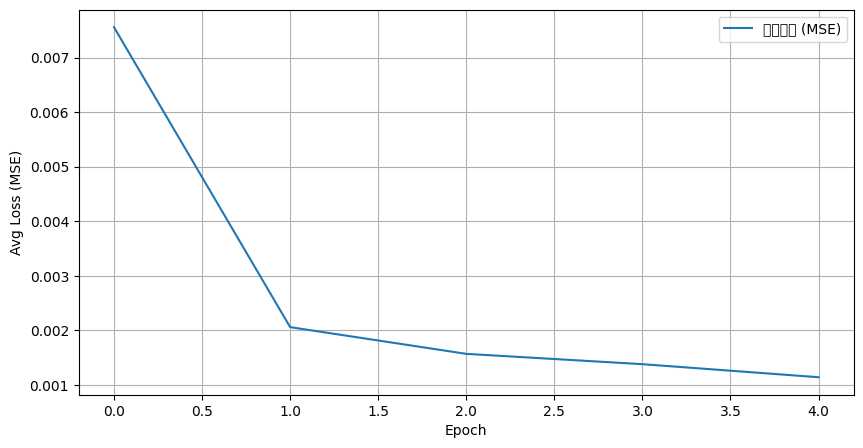

损失曲线图已保存至: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\figures\training_loss_curve_epoch_5.png

训练完成。
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\checkpoints
Checkpoint 已保存至: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\checkpoints\model_final.pt (Epoch 5, Loss 0.0011)
目录已存在: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\figures


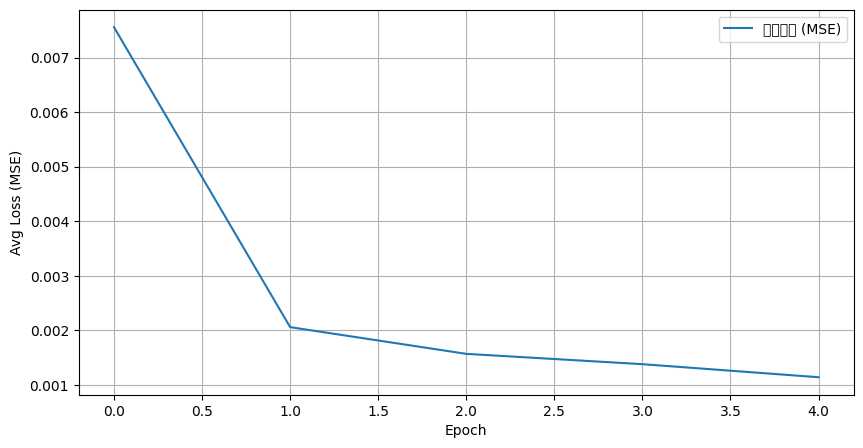

损失曲线图已保存至: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\figures\training_loss_curve_final.png


In [25]:
# 单元格 11: 训练流程

# (必要的导入如 torch, F, DataLoader, DDPMScheduler, get_lr_scheduler, AdamW, 
#  tqdm, plt, os, np 已经在单元格 1 中完成或隐式可用)
# (全局配置变量如 BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS, DEVICE, etc. 已在单元格 1 定义)
# (SSTDataset 类已在单元格 9 定义)
# (get_diffusion_model 函数已在单元格 10 定义)
# (ensure_dir 函数已在单元格 2 定义)

from torch.utils.data import DataLoader # 确保显式导入
from diffusers import DDPMScheduler
from diffusers.optimization import get_scheduler as get_lr_scheduler
from torch.optim import AdamW


# --- 辅助函数 ---
def save_checkpoint(epoch, model, optimizer, loss, filepath):
    """保存模型checkpoint"""
    # ensure_dir 来自单元格 2
    ensure_dir(os.path.dirname(filepath))
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss, # 保存当前epoch的平均loss
    }, filepath)
    print(f"Checkpoint 已保存至: {filepath} (Epoch {epoch}, Loss {loss:.4f})")

def plot_loss_curve(epoch_losses_list, filepath): # 参数名修改以示列表
    """绘制并保存loss曲线图"""
    # ensure_dir 来自单元格 2
    ensure_dir(os.path.dirname(filepath))
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses_list, label='Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Avg Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig(filepath)
    plt.show() 
    print(f"损失曲线图已保存至: {filepath}")

# --- 开始训练的主体代码 ---
print("开始训练流程的主体代码...")

# 0. 再次确保输出目录存在 (config中已定义路径，ensure_dir在单元格2定义)
print("确保输出目录存在...")
ensure_dir(CHECKPOINT_PATH)
ensure_dir(FIGURES_PATH)

# 1. 准备数据 (SSTDataset 在单元格9定义)
print("初始化训练数据集...")
train_dataset = SSTDataset(mode='train') 


train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, # 来自单元格1的配置
    shuffle=True,
    num_workers=0, # 在Windows或某些Notebook环境中, num_workers>0 可能导致问题, 先设为0测试
                   # 如果在Linux上并且没有问题,可以尝试设置为比如 os.cpu_count() // 2
    pin_memory=True if DEVICE == "cuda" else False 
)
print(f"训练数据加载器准备完毕，每个epoch包含 {len(train_dataloader)} 个批次。")

# 2. 初始化模型 (get_diffusion_model 在单元格10定义)
print("初始化模型...")
model = get_diffusion_model() 
print(f"模型参数总数: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model.to(DEVICE)
print(f"模型已移动到设备: {DEVICE}")

# 3. 初始化 DDPM 噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=DDPM_NUM_TRAIN_TIMESTEPS, # 来自单元格1
    beta_schedule=DDPM_BETA_SCHEDULE          # 来自单元格1
)
print(f"DDPM噪声调度器 ({DDPM_BETA_SCHEDULE} schedule, {DDPM_NUM_TRAIN_TIMESTEPS} 步) 已初始化。")

# 4. 初始化优化器
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE) # LEARNING_RATE 来自单元格1
print(f"优化器 AdamW 已初始化，学习率: {LEARNING_RATE}")

# 5. 初始化学习率调度器
num_training_steps_per_epoch = len(train_dataloader)
num_total_training_steps = num_training_steps_per_epoch * NUM_EPOCHS # NUM_EPOCHS 来自单元格1

lr_scheduler = get_lr_scheduler(
    name="linear", 
    optimizer=optimizer,
    num_warmup_steps=0, 
    num_training_steps=num_total_training_steps
)
print(f"学习率调度器 (linear) 已初始化，总训练步数: {num_total_training_steps}")

# 6. 训练循环
print(f"开始训练，共 {NUM_EPOCHS} 轮。")
epoch_losses_history = [] # 用于存储每个epoch的平均损失

for epoch in range(NUM_EPOCHS):
    model.train() 
    running_loss_this_epoch = 0.0 # 重命名以清晰表示是当前epoch的累计损失
    
    progress_bar = tqdm(
        enumerate(train_dataloader), 
        total=len(train_dataloader), 
        desc=f"轮次 {epoch+1}/{NUM_EPOCHS}"
    )

    for step, batch in progress_bar:
        history_patches, target_patch, raw_time_features, raw_spatial_features = batch
        
        history_patches = history_patches.to(DEVICE)     
        target_patch = target_patch.to(DEVICE)          
        raw_time_features = raw_time_features.to(DEVICE) 
        raw_spatial_features = raw_spatial_features.to(DEVICE) 
        

        noise = torch.randn_like(target_patch)
        timesteps = torch.randint(
            0, 
            noise_scheduler.config.num_train_timesteps, 
            (BATCH_SIZE,), 
            device=DEVICE 
        ).long()
        noisy_target_patch = noise_scheduler.add_noise(target_patch, noise, timesteps)
        
        optimizer.zero_grad()
        predicted_noise = model(
            history_patches, 
            noisy_target_patch, 
            timesteps, 
            raw_time_features, 
            raw_spatial_features
        )
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss_this_epoch += loss.item()
        progress_bar.set_postfix({
            "损失": f"{loss.item():.4f}", 
            "学习率": f"{lr_scheduler.get_last_lr()[0]:.2e}"
        })

        if step % LOG_INTERVAL == 0 and step > 0: # LOG_INTERVAL 来自单元格1
             avg_loss_so_far = running_loss_this_epoch / (step + 1)
             print(f"    [轮次 {epoch+1}, 批次 {step}/{len(train_dataloader)}] 平均批次损失: {avg_loss_so_far:.4f}")

    avg_epoch_loss_value = running_loss_this_epoch / len(train_dataloader)
    epoch_losses_history.append(avg_epoch_loss_value)
    print(f"轮次 {epoch+1} 完成。平均训练损失: {avg_epoch_loss_value:.4f}, 当前学习率: {lr_scheduler.get_last_lr()[0]:.2e}")

    if (epoch + 1) % SAVE_EPOCH_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS: # SAVE_EPOCH_INTERVAL 来自单元格1
        checkpoint_filepath = os.path.join(CHECKPOINT_PATH, f"model_epoch_{epoch+1}.pt")
        save_checkpoint(epoch + 1, model, optimizer, avg_epoch_loss_value, checkpoint_filepath)
        
        loss_curve_filepath = os.path.join(FIGURES_PATH, f"training_loss_curve_epoch_{epoch+1}.png")
        plot_loss_curve(epoch_losses_history, loss_curve_filepath)

print("\n训练完成。")
# 最终保存一次模型和loss图 (确保最后的状态被保存)
final_model_path = os.path.join(CHECKPOINT_PATH, "model_final.pt")
final_loss_value = epoch_losses_history[-1] if epoch_losses_history else float('inf')
save_checkpoint(NUM_EPOCHS, model, optimizer, final_loss_value, final_model_path)

final_loss_curve_path = os.path.join(FIGURES_PATH, "training_loss_curve_final.png")
plot_loss_curve(epoch_losses_history, final_loss_curve_path)

In [33]:
# 单元格 12: 推理与评估的辅助函数
from sklearn.metrics import mean_squared_error

def load_checkpoint(filepath,model,device):
    """加载模型checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Checkpoint 已加载: {filepath} (Epoch {checkpoint['epoch']}, Loss {checkpoint['loss']:.4f})")
    return model

def denormalize_sst(normalized_sst_tensor:torch.Tensor,min_val:float,max_val:float) -> torch.Tensor:
    """将数据反归一化到原始范围"""
    if max_val == min_val:
        raise ValueError("max_val 不能等于 min_val")
    original_sst =  (normalized_sst_tensor + 1.0) * (max_val - min_val) / 2.0 + min_val
    return original_sst

def reconstructure_img_from_pathes(
    patches:dict, # key:(r,c) tuple, value: torch.Tensor
    img_dims:tuple, # (height, width)
    patch_size:int,
    stride:int
) -> torch.Tensor:
    """从patch图像重构原始图像,重叠区域取平均"""
    H, W = img_dims
    re_img = torch.zeros((H, W), dtype=torch.float32)
    count_map = torch.zeros((H, W), dtype=torch.float32)

    for (r,c),patch_tensor in patches.items():
        re_img[r:r + patch_size, c:c + patch_size] += patch_tensor
        count_map[r:r + patch_size, c:c + patch_size] += 1
    
    re_img = torch.where(count_map > 0, re_img / count_map, 0.0) # 计算平均值，避免除以0

    return re_img

def calculate_metrics(predicted_np:np.ndarray, target_np:np.ndarray,land_sea_mask_np:np.ndarray):
    """计算predict和target的MSE,RMSE"""

    # 选择海洋点
    ocean_pred = predicted_np[land_sea_mask_np]
    ocean_target = target_np[land_sea_mask_np]

    mse = mean_squared_error(ocean_target, ocean_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

def save_img_comparison(
        predicted_np:np.ndarray,
        target_np:np.ndarray,
        land_sea_mask_np:np.ndarray,
        filepath:str,
        title_prefix:str=""
):
    """"保存pred,target和diff的可视化对比图"""
    ensure_dir(os.path.dirname(filepath))
    pred_masked = np.where(land_sea_mask_np, predicted_np, np.nan)
    target_masked = np.where(land_sea_mask_np, target_np, np.nan)

    fix,axes = plt.subplots(1, 3, figsize=(15, 5))
    im0 = axes[0].imshow(pred_masked,cmap='coolwarm')
    im1 = axes[1].imshow(target_masked, cmap='coolwarm')

    diff_masked = np.where(land_sea_mask_np, predicted_np - target_masked, np.nan)
    im2 = axes[2].imshow(diff_masked, cmap='RdBu_r')

    plt.savefig(filepath)
    plt.show()
    print(f"图像对比图已保存到: {filepath}")

print("单元格 12: 推理与评估的辅助函数已定义。")

单元格 12: 推理与评估的辅助函数已定义。


In [39]:
# 单元格 13: 推理与评估主体流程
from diffusers import DDPMScheduler

# --- 在这里配置本次推理 ---
# 可以在运行前修改这两个变量
checkpoint_to_load = "model_final.pt" 
# 设置为 None 会自动从测试集第一天开始预测, 或指定一个 'YYYY-MM-DD' 格式的日期
inference_start_date_str = "2020-03-01" 
# -------------------------

# --- 主体逻辑开始 ---
print("="*50)
print("开始推理与评估流程...")
print("="*50+'\n')

device = torch.device(DEVICE)  

# 1.基本设置
stats = torch.load(NORMALIZATION_STATS_PATH)
min_sst, max_sst = stats['min_sst'], stats['max_sst']
land_sea_mask = torch.load(LAND_SEA_MASK_PATH)
land_sea_mask_np = land_sea_mask.numpy()  # 转换为numpy数组以便后续处理

print(f"归一化参数： Min_SST = {min_sst:.4f}, Max_SST = {max_sst:.4f}")

model = get_diffusion_model()
model.to(device)  # 确保模型在正确的设备上
model = load_checkpoint(os.path.join(CHECKPOINT_PATH, checkpoint_to_load),model,device)  # 加载模型checkpoint
model.eval()  

noise_scheduler = DDPMScheduler(
    num_train_timesteps=DDPM_NUM_TRAIN_TIMESTEPS, 
    beta_schedule=DDPM_BETA_SCHEDULE
)

noise_scheduler.set_timesteps(DDPM_NUM_INFERENCE_STEPS)  # 设置推理步数
print(f"DDPM噪声调度器已设置为 {DDPM_NUM_INFERENCE_STEPS} 步推理。")

# 2. 准备测试数据集
if inference_start_date_str is None:
    train_end_dt = datetime.strptime(TRAIN_PERIOD_END_DATE, "%Y-%m-%d")
    inference_start_date_dt = train_end_dt + timedelta(days=1)
    inference_start_date_str = inference_start_date_dt.strftime("%Y-%m-%d")
else:
    inference_start_date_dt = datetime.strptime(inference_start_date_str, "%Y-%m-%d")

print(f"将从日期 {inference_start_date_str} 开始进行 {AUTOREGRESSIVE_PREDICT_DAYS} 天的自回归预测。")
print("加载初始历史数据...")
current_history_all_coords = defaultdict(list)
all_spatial_coords = set()
history_start_dt = inference_start_date_dt - timedelta(days=HISTORY_DAYS)

date_range_for_history = []
temp_date = history_start_dt
while temp_date < inference_start_date_dt:
    date_range_for_history.append(temp_date)
    temp_date += timedelta(days=1)

for current_dt in tqdm(date_range_for_history, desc="加载历史数据"):
    date_str = current_dt.strftime("%Y-%m-%d")
    file_path = os.path.join(PATCHES_PATH, f"{date_str}_patches.pt")
    if os.path.exists(file_path):
        patches = torch.load(file_path, map_location=device)
        for patch in patches:
            coords = tuple(patch['coords'])
            all_spatial_coords.add(coords)
            current_history_all_coords[coords].append(patch['sst_patch'])
    else:
        print(f"警告: 文件 {file_path} 不存在，跳过加载。")

valid_coords = [coords for coords in all_spatial_coords if len(current_history_all_coords[coords]) == HISTORY_DAYS]
if len(valid_coords) < len(all_spatial_coords):
    print(f"警告: 并非所有坐标都有完整的30天历史。将只对 {len(valid_coords)} 个坐标进行预测。")
if not valid_coords:
    raise ValueError("错误: 没有可用于预测的完整初始历史数据。推理中止。")

ref_year = datetime.strptime(DATA_START_DATE, "%Y-%m-%d").year
evaluation_metrics = {f"Tplus{i+1}":[] for i in range(AUTOREGRESSIVE_PREDICT_DAYS)}

# 3. 推理循环
with torch.no_grad():
    for day in range(AUTOREGRESSIVE_PREDICT_DAYS):
        target_pred_dt = inference_start_date_dt + timedelta(days=day)
        target_date_str = target_pred_dt.strftime("%Y-%m-%d")
        lead_time_key = f"Tplus{day+1}"  # 用于存储评估结果的键
        print(f"\n正在预测 {target_date_str} 的数据...")

        predicted_patches = {}

        for coords in tqdm(list(valid_coords), desc=f"预测Patches:{target_date_str}"):
            # 准备历史数据
            history_sequence_list = current_history_all_coords[coords]
            history_tensor = torch.stack(history_sequence_list).unsqueeze(0).to(device)  # (1, HISTORY_DAYS, H, W)

            # time and spatial features
            time_feat = get_time_features(target_date_str, reference_year=ref_year).unsqueeze(0).to(device)
            spatial_feat = get_spatial_features(coords, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH), PATCH_SIZE).unsqueeze(0).to(device)

            noisy_patch_sample = torch.randn(1,UNET_OUT_CHANNELS,PATCH_SIZE,PATCH_SIZE, device=device)  # (1, C, H, W)

            for t in noise_scheduler.timesteps:
                timestep_tensor = torch.tensor([t], device=device).long()  # 转换为tensor并移动到设备
                model_output_noise = model(history_tensor, noisy_patch_sample, timestep_tensor, time_feat, spatial_feat)
                noisy_patch_sample = noise_scheduler.step(model_output_noise,t,noisy_patch_sample).prev_sample

            pred_path_normalized = noisy_patch_sample.squeeze(0).squeeze(0) 
            predicted_patches[coords] = pred_path_normalized

            # 自回归使用新的预测结果更新历史
            if day < AUTOREGRESSIVE_PREDICT_DAYS - 1:
                new_history = history_sequence_list[1:] + [pred_path_normalized.detach().clone()]
                current_history_all_coords[coords] = new_history
        
        # 重构预测图像
        print(f"重建图像...")
        full_pred_img_norm = reconstructure_img_from_pathes(
            predicted_patches,
            img_dims=(IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH),
            patch_size=PATCH_SIZE,
            stride=STRIDE
        )
        full_pred_img_denorm = denormalize_sst(full_pred_img_norm, min_sst, max_sst).numpy()
        target_img_denorm_np = None
        target_img_filename = FILENAME_TEMPLATE.format(date_str=target_pred_dt.strftime("%Y-%m-%d"))
        target_img_path = os.path.join(DATA_RAW_PATH, target_img_filename)
        if os.path.exists(target_img_path):
            target_sst_raw,_,_ = load_single_nc_file(target_img_path)
            target_cropped = crop_image(target_sst_raw, IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH)
            target_img_denorm_np = target_cropped.values
        
            # 计算评估指标
            mse,rmse = calculate_metrics(full_pred_img_denorm, target_img_denorm_np, land_sea_mask_np)
            print(f"  评估结果 ({lead_time_key}, {target_date_str}): RMSE = {rmse:.4f}, MSE = {mse:.4f}")
            evaluation_metrics[lead_time_key].append({'date': target_date_str, 'rmse': rmse, 'mse': mse})
        else:
            print(f"警告: 目标图像文件 {target_img_path} 不存在，无法计算评估指标。")

# 5. 打印最终的评估指标总结
print("\n" + "="*50)
print("--- 最终评估指标总结 (针对此次推理序列) ---")
print("="*50)
for lead_time, metrics_list in evaluation_metrics.items():
    if not metrics_list:
        print(f"{lead_time}: 无评估数据")
        continue
    avg_rmse = np.nanmean([m['rmse'] for m in metrics_list])
    avg_mse = np.nanmean([m['mse'] for m in metrics_list])
    print(f"{lead_time} - 平均 RMSE: {avg_rmse:.4f}, 平均 MSE: {avg_mse:.4f}")

开始推理与评估流程...

归一化参数： Min_SST = 269.4762, Max_SST = 306.9226
初始化模型: DiffusionUNetWithMLP (基于 UNet2DModel)
Checkpoint 已加载: d:\SCUT\Second Year\Second Semester\DeepLearningProject\SST_Prediciton\results\checkpoints\model_final.pt (Epoch 5, Loss 0.0011)
DDPM噪声调度器已设置为 50 步推理。
将从日期 2020-03-01 开始进行 3 天的自回归预测。
加载初始历史数据...


加载历史数据:   0%|          | 0/30 [00:00<?, ?it/s]


正在预测 2020-03-01 的数据...


预测Patches @ 2020-03-01:   0%|          | 0/924 [00:00<?, ?it/s]

KeyboardInterrupt: 